# 卷积神经网络（LeNet）

LeNet（LeNet-5）由两个部分组成：
卷积编码器和全连接层密集块

In [1]:
import sys
sys.path.append('..')

In [2]:
from d2l import mindspore as d2l
from mindspore import nn, ops, value_and_grad

net = nn.SequentialCell([
    nn.Conv2d(1, 6, kernel_size=5, padding=2, pad_mode='pad', weight_init='xavier_uniform'), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5, pad_mode='valid', weight_init='xavier_uniform'), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Dense(16 * 5 * 5, 120, weight_init='xavier_uniform'), nn.Sigmoid(),
    nn.Dense(120, 84, weight_init='xavier_uniform'), nn.Sigmoid(),
    nn.Dense(84, 10, weight_init='xavier_uniform')
])

检查模型

In [3]:
X = ops.randn(1, 1, 28, 28)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape: 	 (1, 6, 28, 28)
Sigmoid output shape: 	 (1, 6, 28, 28)
AvgPool2d output shape: 	 (1, 6, 14, 14)
Conv2d output shape: 	 (1, 16, 10, 10)
Sigmoid output shape: 	 (1, 16, 10, 10)
AvgPool2d output shape: 	 (1, 16, 5, 5)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Sigmoid output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Sigmoid output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


LeNet在Fashion-MNIST数据集上的表现

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

对
`evaluate_accuracy`函数进行轻微的修改

In [5]:
def evaluate_accuracy_gpu(net, dataset, device=None): 
    """使用GPU计算模型在数据集上的精度。"""
    net.set_train(False)
    metric = d2l.Accumulator(2)
    for X, y in dataset.create_tuple_iterator():
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

In [6]:
def train_ch6(net, train_dataset, test_dataset, num_epochs, lr):
    """用GPU训练模型(在第六章定义)。"""
    optim = nn.SGD(net.trainable_params(), learning_rate=lr)
    loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

    # 定义前向传播函数
    def forward_fn(x, y):
        y_hat = net(x)
        loss = loss_fn(y_hat, y)
        return loss, y_hat
    grad_fn = value_and_grad(forward_fn, None, weights=net.trainable_params(), has_aux=True)
    
    # 定义模型单步训练
    def train(X, Y, optim):
        (loss, y_hat), grads = grad_fn(X, Y)
        loss = ops.depend(loss, optim(grads))
        return loss, y_hat
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), train_dataset.get_dataset_size()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.set_train()
        for i, (X, y) in enumerate(train_dataset.create_tuple_iterator()):
            timer.start()
            loss, y_hat = train(X, y, optim)
            metric.add(loss.asnumpy() * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_dataset)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec')

训练和评估LeNet-5模型

loss 0.470, train acc 0.837, test acc 0.819
52451.5 examples/sec


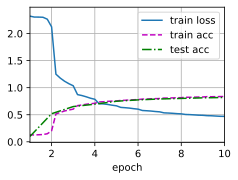

In [7]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)